In [1]:
import os, pandas as pd
import csv, json, nrrd, numpy as np
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = 'E:/Datasets/Annotation Analysis'
ANNOTATIONS_PATH = 'E:/Datasets/Annotations/Analysis Annotations'
DATA_FILE_PATH = 'E:/Datasets/Annotation Analysis/Data.csv'
NRRD_PATH = 'E:/Datasets/Echocardio/CU/'
RESULT_PATH = 'E:/Datasets/Annotation Analysis/results'
GRAPH_PATH = 'E:/Datasets/Annotation Analysis/graphs'

In [3]:
OUTPUT_GRAPH = False

In [4]:
NRRD_FILES_PATHS = {}
for root, dirs, files in os.walk(NRRD_PATH):
    for file in files:
        NRRD_FILES_PATHS[file[0:-9]] = os.path.join(root, file)

JSON_FILES_PATHS = {}
for root, dirs, files in os.walk(ANNOTATIONS_PATH):
    for file in files:
        JSON_FILES_PATHS[file[0:-5]] = os.path.join(root, file)

In [5]:
point_total_count = 0
point_count = {}

with open(DATA_FILE_PATH, 'r') as data_file:
    reader = csv.reader(data_file)
    for i, line in enumerate(reader):
        if i == 0:
            continue
        view = line[0].strip('., ')

        structures_in_csv = line[1].split(',')
        structure_list = []
        for structure in structures_in_csv:
            structure_list.append(structure.strip('., '))
        
        point_count[view] = {x: 0 for x in structure_list}

In [6]:
for file_name, json_file_path in JSON_FILES_PATHS.items():
    point_total_count += 1
    with open(json_file_path, 'r') as json_file:
        json_data = json.load(json_file)
        fid_data = json_data['fidData']
        for fid in fid_data:
            view = fid['View Name'].strip('., ')
            structure = fid['Structure Name'].strip('., ')
            point_count[view][structure] += 1

In [7]:
print(point_count)
print('Total Point:', point_total_count)

{'4 chamber view (A4C)': {'MV tip': 58, 'A4C-TV tip': 58, 'A4C-LV apex': 56, 'Medial mitral annulus': 58, 'Lateral mitral annulus': 58, 'Tricuspid annulus': 58}, '2 chamber view (A2C)': {'A2C-LV apex': 58, 'Anterolateral mitral annulus': 58, 'Posteromedial mitral annulus': 58}, 'Long-axis view (ALAX)': {'ALAX-LV apex': 56, 'Aortic annulus': 57, 'Anterior mitral annulus': 57, 'Posterior mitral annulus': 57}, 'Basal short-axis view (SAXB)': {'Center of AV': 48, 'IAS': 48, 'SAXB-TV tip': 47, 'PV tip': 0}, 'MV short-axis view (SAXMV)': {'MV anterior leaflet A1': 54, 'MV anterior leaflet  A2': 54, 'MV anterior leaflet  A3': 54, 'MV posterior leaflet P1': 54, 'MV posterior leaflet P2': 54, 'MV posterior leaflet P3': 54}, 'Mid LV short-axis view (SAXM)': {'Anterolateral papillary muscle': 28, 'Posteromedial papillary muscle': 31, 'IVS': 58, 'IW': 58, 'LV': 58, 'RV': 58}, 'Apical LV short-axis view (SAXA)': {'SAXA-LV apex': 55, 'Interventricular septum': 55, 'RV apex': 55}}
Total Point: 58


In [8]:
pointsCenters = {}
nrrdFileHeaders = {}
nrrdFileDataShapes = {}
nrrdTimeLengths = {}

In [9]:
centers = []
for file_name, json_file_path in JSON_FILES_PATHS.items():
    nrrd_file_path = NRRD_FILES_PATHS[file_name]
    f = nrrd.read(nrrd_file_path, index_order='C')
    nrrdFileHeader = f[1]
    nrrdFileDataShape = np.array([f[0].shape[2], f[0].shape[1], f[0].shape[0]])
    nrrdTimeLength = f[0].shape[3]

    points = []
    with open(json_file_path, 'r') as json_file:
        json_data = json.load(json_file)
        fid_data = json_data['fidData']
        for fid in fid_data:
            view = fid['View Name'].strip('., ')
            structure = fid['Structure Name'].strip('., ')
            if point_count[view][structure] == point_total_count:
                points.append(fid['Position-IJK'])
    
    points = np.array(points)
    points_mean = np.mean(points, axis=0) / nrrdFileDataShape

    pointsCenters[file_name] = points_mean
    nrrdFileHeaders[file_name] = nrrdFileHeader
    nrrdFileDataShapes[file_name] = nrrdFileDataShape
    nrrdTimeLengths[file_name] = nrrdTimeLength
    centers.append(points_mean)
    
centers = np.array(centers)

center = np.mean(centers, axis=0)

In [10]:
data_points_abs_no_offset = {}    # Absolute Value without center offset
data_points_abs_offset = {}    # Absolute Value with center offset

data_points_prop_no_offset = {}    # Proportional Value without center offset
data_points_prop_offset = {}    # Proportional Value with center offset
for file_name, json_file_path in JSON_FILES_PATHS.items():
    offset_prop = pointsCenters[file_name] - center
    offset_abs = offset_prop * nrrdFileDataShapes[file_name]
    with open(json_file_path, 'r') as json_file:
        json_data = json.load(json_file)
        fid_data = json_data['fidData']
        for fid in fid_data:
            view = fid['View Name'].strip('., ')
            structure = fid['Structure Name'].strip('., ')
            
            if view not in data_points_abs_no_offset:
                data_points_abs_no_offset[view] = {}
            if structure not in data_points_abs_no_offset[view]:
                data_points_abs_no_offset[view][structure] = []
            data_points_abs_no_offset[view][structure].append(fid['Position-IJK'])
            
            if view not in data_points_abs_offset:
                data_points_abs_offset[view] = {}
            if structure not in data_points_abs_offset[view]:
                data_points_abs_offset[view][structure] = []
            data_points_abs_offset[view][structure].append(np.array(fid['Position-IJK']) - offset_abs)
            
            if view not in data_points_prop_no_offset:
                data_points_prop_no_offset[view] = {}
            if structure not in data_points_prop_no_offset[view]:
                data_points_prop_no_offset[view][structure] = []
            data_points_prop_no_offset[view][structure].append(np.array(fid['Position-IJK'])/nrrdFileDataShapes[file_name])
            
            if view not in data_points_prop_offset:
                data_points_prop_offset[view] = {}
            if structure not in data_points_prop_offset[view]:
                data_points_prop_offset[view][structure] = []
            data_points_prop_offset[view][structure].append(np.array(fid['Position-IJK'])/nrrdFileDataShapes[file_name] - offset_prop)

In [11]:
view_colour = {
    '4 chamber view (A4C)': 'r',
    '2 chamber view (A2C)': 'g',
    'Long-axis view (ALAX)': 'b',
    'Basal short-axis view (SAXB)': 'c',
    'MV short-axis view (SAXMV)': 'm',
    'Mid LV short-axis view (SAXM)': 'y',
    'Apical LV short-axis view (SAXA)': 'k',
}

In [12]:
# Volume Range
allShapes = []
for file_name, volume_shape in nrrdFileDataShapes.items():
    allShapes.append(volume_shape)
allShapes = np.array(allShapes)
print('Shape Min:', np.min(allShapes, axis=0))
print('Shape Max:', np.max(allShapes, axis=0))
print('Shape Mean:', np.mean(allShapes, axis=0))
print('Shape SD:', np.std(allShapes, axis=0))

Shape Min: [224 144 208]
Shape Max: [288 224 208]
Shape Mean: [240.27586207 178.75862069 208.        ]
Shape SD: [23.10828565 21.24675257  0.        ]


In [13]:
# Abosolute Value Range
points_range = [['View', 'Structure', 'Min i', 'Min j', 'Min k',  'Max i', 'Max j', 'Max k']]
for view, view_dict in data_points_abs_no_offset.items():
    for structure, structure_points in view_dict.items():
        structure_points_np = np.array(structure_points)
        structure_points_min = np.min(structure_points_np, axis=0)
        structure_points_max = np.max(structure_points_np, axis=0)
        points_range.append([view, structure] + structure_points_min.tolist() + structure_points_max.tolist())
        
with open(os.path.join(RESULT_PATH, 'points_range.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(points_range)

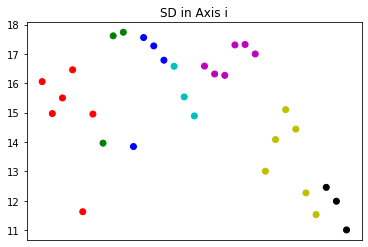

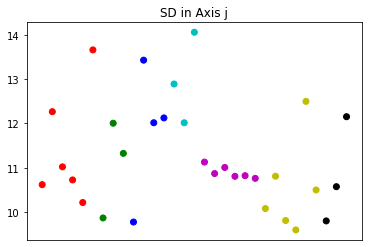

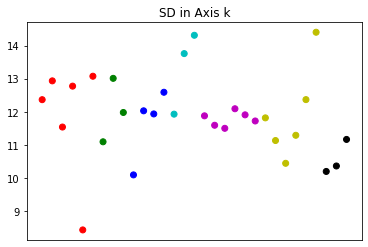

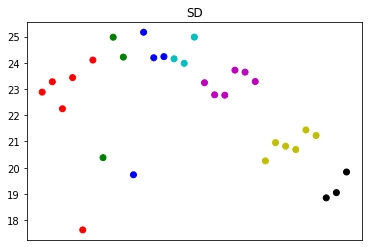

<Figure size 432x288 with 0 Axes>

In [14]:
# Absolute Value without center offset
abs_no_offset_sd_i = []
abs_no_offset_sd_j = []
abs_no_offset_sd_k = []
abs_no_offset_sd = []
colours = []
for view, view_dict in data_points_abs_no_offset.items():
    for structure, structure_points in view_dict.items():
        structure_points_np = np.array(structure_points)
        structure_points_mean = np.mean(structure_points_np, axis=0)
        # Per axis sd
        structure_points_axis_sd = np.std(structure_points_np, axis=0)
        
        # Absolute sd
        structure_points_sd = np.sqrt(np.sum(np.power(np.linalg.norm(structure_points_np - structure_points_mean, axis=1), 2)) / len(structure_points))
        #print(view, structure, structure_points_mean, structure_points_axis_sd, structure_points_absolute_sd)
        abs_no_offset_sd_i.append(structure_points_axis_sd[0])
        abs_no_offset_sd_j.append(structure_points_axis_sd[1])
        abs_no_offset_sd_k.append(structure_points_axis_sd[2])
        abs_no_offset_sd.append(structure_points_sd)
        colours.append(view_colour[view])
        
x_coor = range(len(abs_no_offset_sd_i))

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('SD in Axis i')
plt.scatter(x_coor, abs_no_offset_sd_i, color=colours)
#import matplotlib.patches as mpatches
#handles, labels = plt.gca().get_legend_handles_labels()
#handles.extend([mpatches.Patch(color=c, label=l) for l, c in view_colour.items()])
#plt.legend(handles=handles, bbox_to_anchor=(1.05, 1.0), loc='upper left')
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'sd_i.png'))
plt.show()
plt.clf()

plt.title('SD in Axis j')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_no_offset_sd_j, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'sd_j.png'))
plt.show()
plt.clf()

plt.title('SD in Axis k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_no_offset_sd_k, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'sd_k.png'))
plt.show()
plt.clf()

plt.title('SD')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_no_offset_sd, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'sd.png'))
plt.show()
plt.clf()

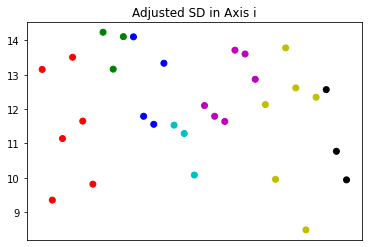

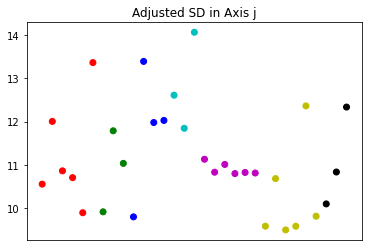

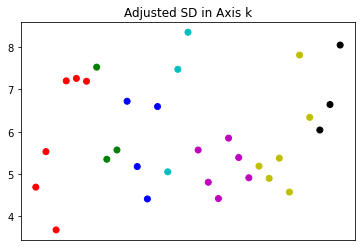

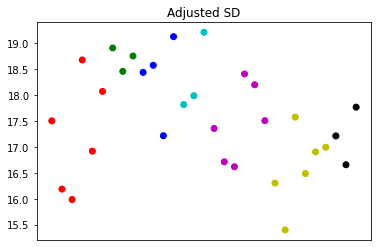

<Figure size 432x288 with 0 Axes>

In [15]:
# Absolute Value with center offset
abs_offset_sd_i = []
abs_offset_sd_j = []
abs_offset_sd_k = []
abs_offset_sd = []
for view, view_dict in data_points_abs_offset.items():
    for structure, structure_points in view_dict.items():
        structure_points_np = np.array(structure_points)
        structure_points_mean = np.mean(structure_points_np, axis=0)
        # Per axis sd
        structure_points_axis_sd = np.std(structure_points_np, axis=0)
        
        # Absolute sd
        structure_points_sd = np.sqrt(np.sum(np.power(np.linalg.norm(structure_points_np - structure_points_mean, axis=1), 2)) / len(structure_points))
        #print(view, structure, structure_points_mean, structure_points_axis_sd, structure_points_sd)
        
        abs_offset_sd_i.append(structure_points_axis_sd[0])
        abs_offset_sd_j.append(structure_points_axis_sd[1])
        abs_offset_sd_k.append(structure_points_axis_sd[2])
        abs_offset_sd.append(structure_points_sd)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Adjusted SD in Axis i')
plt.scatter(x_coor, abs_offset_sd_i, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_sd_i.png'))
plt.show()
plt.clf()

plt.title('Adjusted SD in Axis j')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_offset_sd_j, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_sd_j.png'))
plt.show()
plt.clf()

plt.title('Adjusted SD in Axis k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_offset_sd_k, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_sd_k.png'))
plt.show()
plt.clf()

plt.title('Adjusted SD')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, abs_offset_sd, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_sd.png'))
plt.show()
plt.clf()    

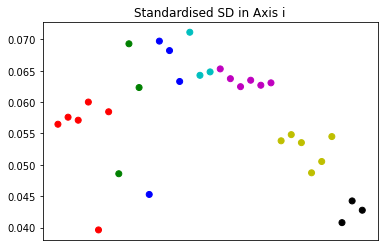

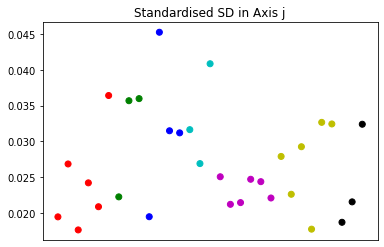

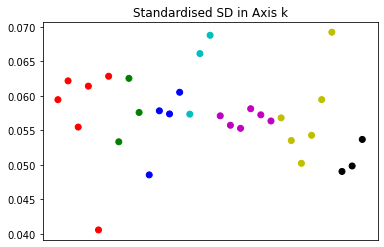

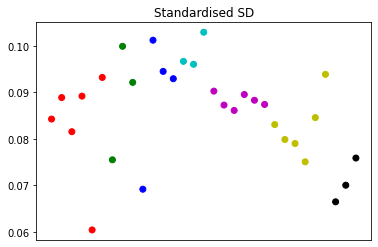

<Figure size 432x288 with 0 Axes>

In [16]:
# Proportional Value without center offset
prop_no_offset_sd_i = []
prop_no_offset_sd_j = []
prop_no_offset_sd_k = []
prop_no_offset_sd = []
for view, view_dict in data_points_prop_no_offset.items():
    for structure, structure_points in view_dict.items():
        structure_points_np = np.array(structure_points)
        structure_points_mean = np.mean(structure_points_np, axis=0)
        # Per axis sd
        structure_points_axis_sd = np.std(structure_points_np, axis=0)
        
        # Absolute sd
        structure_points_sd = np.sqrt(np.sum(np.power(np.linalg.norm(structure_points_np - structure_points_mean, axis=1), 2)) / len(structure_points))
        #print(view, structure, structure_points_mean, structure_points_axis_sd, structure_points_sd)
        
        prop_no_offset_sd_i.append(structure_points_axis_sd[0])
        prop_no_offset_sd_j.append(structure_points_axis_sd[1])
        prop_no_offset_sd_k.append(structure_points_axis_sd[2])
        prop_no_offset_sd.append(structure_points_sd)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Standardised SD in Axis i')
plt.scatter(x_coor, prop_no_offset_sd_i, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'std_sd_i.png'))
plt.show()
plt.clf()

plt.title('Standardised SD in Axis j')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_no_offset_sd_j, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'std_sd_j.png'))
plt.show()
plt.clf()

plt.title('Standardised SD in Axis k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_no_offset_sd_k, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'std_sd_k.png'))
plt.show()
plt.clf()

plt.title('Standardised SD')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_no_offset_sd, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'std_sd.png'))
plt.show()
plt.clf()    

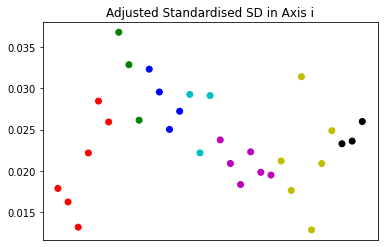

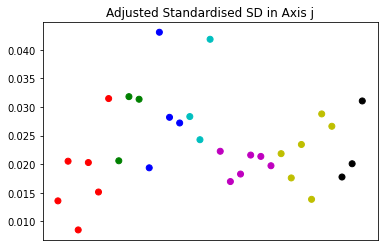

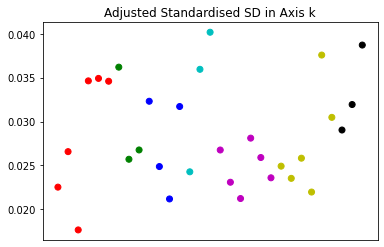

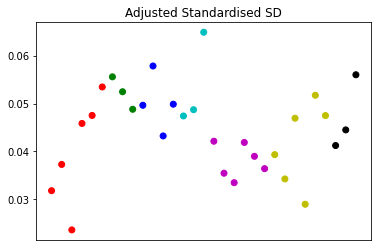

<Figure size 432x288 with 0 Axes>

In [17]:
# Proportional Value with center offset
prop_offset_sd_i = []
prop_offset_sd_j = []
prop_offset_sd_k = []
prop_offset_sd = []
for view, view_dict in data_points_prop_offset.items():
    for structure, structure_points in view_dict.items():
        structure_points_np = np.array(structure_points)
        structure_points_mean = np.mean(structure_points_np, axis=0)
        # Per axis sd
        structure_points_axis_sd = np.std(structure_points_np, axis=0)
        
        # Absolute sd
        structure_points_sd = np.sqrt(np.sum(np.power(np.linalg.norm(structure_points_np - structure_points_mean, axis=1), 2)) / len(structure_points))
        if 0.13 < structure_points_sd < 0.2:
            print(view, structure, structure_points_mean, structure_points_axis_sd, structure_points_sd)
        
        prop_offset_sd_i.append(structure_points_axis_sd[0])
        prop_offset_sd_j.append(structure_points_axis_sd[1])
        prop_offset_sd_k.append(structure_points_axis_sd[2])
        prop_offset_sd.append(structure_points_sd)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Adjusted Standardised SD in Axis i')
plt.scatter(x_coor, prop_offset_sd_i, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_std_sd_i.png'))
plt.show()
plt.clf()

plt.title('Adjusted Standardised SD in Axis j')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_offset_sd_j, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_std_sd_j.png'))
plt.show()
plt.clf()

plt.title('Adjusted Standardised SD in Axis k')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_offset_sd_k, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_std_sd_k.png'))
plt.show()
plt.clf()

plt.title('Adjusted Standardised SD')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.scatter(x_coor, prop_offset_sd, color=colours)
if OUTPUT_GRAPH:
    plt.savefig(os.path.join(GRAPH_PATH, 'adj_std_sd.png'))
plt.show()
plt.clf()    